In [1]:
%matplotlib inline
import numpy as np
import nengo
import matplotlib.pyplot as plt

We start be defining a pure delay dynapse, as there isn't one built in to Nengo

In [31]:
class DiscreteDelay(nengo.synapses.Synapse):
    def __init__(self, delay, size_in=1):
        self.delay = delay
        super().__init__(default_size_in=size_in, default_size_out=size_in)

    def make_state(self, shape_in, shape_out, dt, dtype=None, y0=None):
        return {}

    def make_step(self, shape_in, shape_out, dt, rng, state=None):
        steps = int(self.delay/dt)
        if steps == 0:
            def step_delay(t, x):
                return x
            return step_delay
        assert steps > 0

        state = np.zeros((steps, shape_in[0]))
        state_index = np.array([0])

        def step_delay(t, x, state=state, state_index=state_index):
            result = state[state_index]
            state[state_index] = x
            state_index[:] = (state_index + 1) % state.shape[0]
            return result

        return step_delay

Now we actually build our model.  Here's the various components:
- $c$ the context signal being used to make the prediction (i.e. the input to the network)
- $z$ the value to be predicted (in this case it's just the first dimension of $c$)
- $t_{delay}$ the amount of time into the future to predict
- $z_{pred}$ the actual prediction.  Ideally, $z_pred(t) = z(t+t_{delay})$

In [49]:
freq = 5
learning_rate = 5e-5
t_delay = 0.05
seed = 4

model = nengo.Network()
with model:
    model.config[nengo.Connection].synapse = None   # set the default synapse to None (normal default is 0.005s)
    
    # the input to the network
    def stim_func(t):
        return np.sin(t*2*np.pi*freq), np.cos(t*2*np.pi*freq)
    c = nengo.Node(stim_func)

    # the value to be predicted (which in this case is just the first dimension of the input)
    z = nengo.Node(None, size_in=1)
    nengo.Connection(c[0], z)
    
    
    z_pred = nengo.Node(None, size_in=1)
    
    # make the hidden layer
    ens = nengo.Ensemble(n_neurons=1000, dimensions=c.size_out, 
                         neuron_type=nengo.LIFRate(), seed=seed)
    nengo.Connection(c, ens)

    # make the output weights we can learn
    conn = nengo.Connection(ens.neurons, z_pred, 
            transform=np.zeros((z_pred.size_in, ens.n_neurons)),   # change this if you have pre-recorded weights to use
            learning_rule_type=nengo.PES(learning_rate=learning_rate,
                                         pre_synapse=DiscreteDelay(t_delay) # delay the activity value when updating weights
                                        ))
                           
    # compute the error by subtracting the current measurement from a delayed version of the predicton
    error = nengo.Node(None, size_in=1)
    nengo.Connection(z_pred, error, synapse=DiscreteDelay(t_delay))
    nengo.Connection(z, error, transform=-1)
    # apply the error to the learning rule
    nengo.Connection(error, conn.learning_rule)

    # record the input to the network
    p_c = nengo.Probe(c)
    # record the value to be predicted
    p_z = nengo.Probe(z)
    # record the prediction
    p_z_pred = nengo.Probe(z_pred)
    #record the weights (but only every 0.1 seconds just to save memory)
    p_weights = nengo.Probe(conn, 'weights', sample_every=0.1)

Now let's run the model

In [50]:
sim = nengo.Simulator(model)
sim.run(20)   # number of seconds to run

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

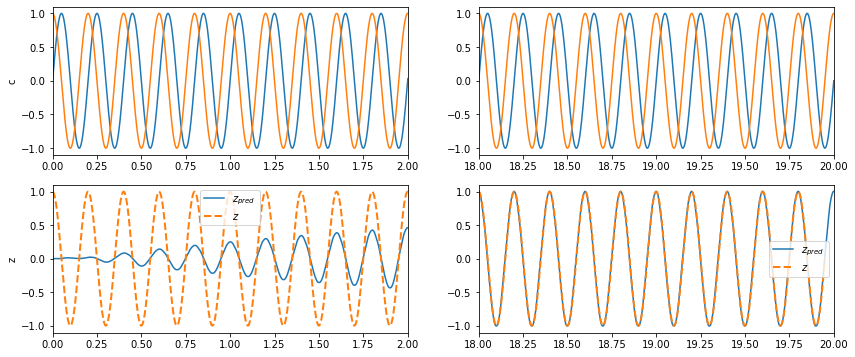

In [51]:
plt.figure(figsize=(14,6))
plt.subplot(2, 2, 1)
plt.plot(sim.trange(), sim.data[p_c])
plt.xlim(0, 2)
plt.ylabel('c')
plt.subplot(2, 2, 2)
plt.plot(sim.trange(), sim.data[p_c])
plt.xlim(18, 20)
plt.subplot(2, 2, 3)
plt.plot(sim.trange(), sim.data[p_z_pred], label='$z_{pred}$')
plt.plot(sim.trange()-t_delay, sim.data[p_z], ls='--', lw=2, label='$z$')
plt.legend()
plt.ylabel('z')
plt.xlim(0, 2)
plt.subplot(2, 2, 4)
plt.plot(sim.trange(), sim.data[p_z_pred], label='$z_{pred}$')
plt.plot(sim.trange()-t_delay, sim.data[p_z], ls='--', lw=2, label='$z$')
plt.legend()
plt.xlim(18, 20)
plt.show()


We can also access the weights by using the probe on the weights.  We only really care about the last value, so let's just plot that.

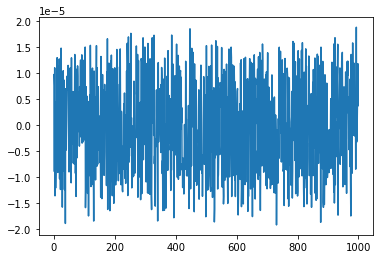

In [52]:
plt.plot(sim.data[p_weights][-1].T)
plt.show()

Now let's try packaging this up as a model where we can initialize this learned model and try controlling how it is run (rather than just running it for 20,000 time steps.

For this case, we recreate the network, using the learned weights.  In this case for simplicity my rebuilt network does not have the learning in it -- we could also include the learning here if we wanted.

To interface with this code, we define a ```step``` function which takes in the current context $c$ value and returns the current prediction $z_{pred}$ from the model.

In [68]:
class Predictor(object):
    def __init__(self, weights, seed, n_neurons, c_init):
        self.model = nengo.Network()
        self.c = np.array(c_init)
        self.z_pred = np.zeros(weights.shape[0])
        with self.model:
            c = nengo.Node(lambda t: self.c)
            
            def set_z_pred(t, x):
                self.z_pred[:] = x
            z_pred = nengo.Node(set_z_pred, size_in=weights.shape[0])
    
            ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=len(self.c), 
                                 neuron_type=nengo.LIFRate(), seed=seed)
            nengo.Connection(c, ens, synapse=None)

            conn = nengo.Connection(ens.neurons, z_pred, 
                                    transform=weights, synapse=None)
            
        self.sim = nengo.Simulator(self.model, dt=0.001, progress_bar=False)
        
    def step(self, c):
        self.c[:] = c
        self.sim.run(0.001)
        return self.z_pred
    
    def reset(self):
        self.sim.reset()
                           
predictor = Predictor(weights=sim.data[p_weights][-1], seed=seed, n_neurons=1000, c_init=[0,0])

Now we can just call `step` with our current input and get an output.

In [70]:
predictor.step(c=[1,0])

array([-0.02771848])